# **Exercise 02: bar**

Prepare the project:

In [1]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import allowed modules:

In [3]:
import sqlite3

import pandas as pd

Import allowed entities:

In [4]:
from pandas import DataFrame
from sqlite3 import Connection
from warnings import filterwarnings
from matplotlib.axes._axes import Axes

Ignore all warnings:

In [5]:
filterwarnings("ignore", )

Create a dictionary for connection to the database:

In [6]:
conn_params: dict = {"db_file": "checking_logs.sqlite", "db_file_path": "../../data/", }

Make a connection to the [database](https://drive.google.com/open?id=1zQ8AR2Ry3ajzB3UZO1Sfk3xtDJlzQF2M):

In [7]:
conn: Connection = sqlite3.connect(conn_params["db_file_path"] + conn_params["db_file"], )

Check connection:

In [8]:
conn.cursor().execute("SELECT 123;", );

## Analyze only the users and not the admins:

Create a query:

In [9]:
sql_q: str = """
             SELECT
                 checker.timestamp AS datetime
             FROM
                 checker
             WHERE
                 checker.uid LIKE 'user_%';
             """

Run a query:

In [10]:
df: DataFrame = pd.io.sql.read_sql(
    sql_q,
    conn,
    parse_dates=["datetime", ],
)

Chech result:

In [11]:
df.head()

,datetime
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


Create a data for creating a new column:

In [12]:
bins: list = [
    0,
    4,
    10,
    17,
    24,
]
labels: list = [
    "night",
    "morning",
    "afternoon",
    "evening",
]

## Night is from `0:00:00` to `03:59:59`, morning is from `04:00:00` to `09:59:59`, afternoon is from `10:00:00` to `16:59:59`, evening is from `17:00:00` to `23:59:59`:

In [13]:
df["period"] = pd.cut(
    df["datetime"].dt.hour,
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True,
)

Check new *Pandas* dataframe column:

In [14]:
df.head()

,datetime,period
0,2020-04-17 05:19:02.744528,morning
1,2020-04-17 05:22:35.249331,morning
2,2020-04-17 05:22:45.549397,morning
3,2020-04-17 05:34:14.691200,morning
4,2020-04-17 05:34:24.422370,morning


Prepare `date` column for visualization:

In [15]:
df["date"] = df["datetime"].dt.date

Check updated *Pandas* dataframe:

In [16]:
df.head()

,datetime,period,date
0,2020-04-17 05:19:02.744528,morning,2020-04-17
1,2020-04-17 05:22:35.249331,morning,2020-04-17
2,2020-04-17 05:22:45.549397,morning,2020-04-17
3,2020-04-17 05:34:14.691200,morning,2020-04-17
4,2020-04-17 05:34:24.422370,morning,2020-04-17


Aggregate data for pivot table:

In [17]:
agg_df: DataFrame = df.groupby(["date", "period", ], ).size().reset_index(name="commits", )

Check aggregated *Pandas* dataframe:

In [18]:
agg_df.head()

,date,period,commits
0,2020-04-17,night,0
1,2020-04-17,morning,13
2,2020-04-17,afternoon,10
3,2020-04-17,evening,0
4,2020-04-18,night,0


Create a pivot table for visualization:

In [19]:
pivot_df: DataFrame = agg_df.pivot(
    index="date",
    columns="period",
    values="commits",
).fillna(0, )

Check a pivot table:

In [20]:
pivot_df.head()

period,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25


## The `fontsize=` and the `figsize=` are still the same.

## Choose a palette:

In [21]:
palette: dict = {
    "morning": "red",
    "evening": "blue",
    "afternoon": "green",
    "night": "purple",
}

Draw a barplot:

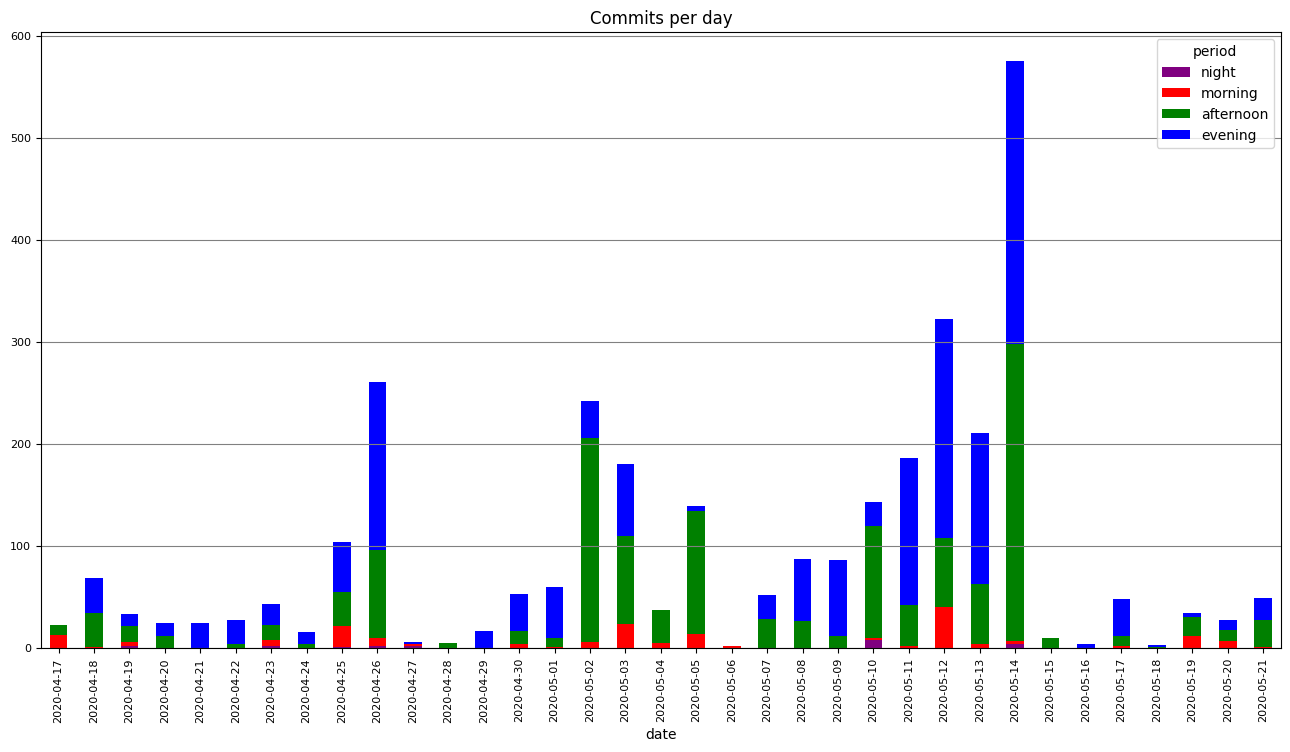

In [22]:
ax: Axes = pivot_df.plot(
    rot=90,
    kind="bar",
    fontsize=8,
    stacked=True,
    color=palette,
    figsize=(16, 8, ),
    title="Commits per day",
)

ax.grid(
    axis='y',
    visible=True,
    color="grey",
    which="major",
    linestyle='-',
)

Create a temporary *Pandas* dataframe to answer on the question:

In [23]:
tmp_df: DataFrame = df.drop(columns=["datetime", ]).groupby("period", ).count().sort_values(by=["date", ], )

Check it:

In [24]:
tmp_df.head()

,date
period,
night,21
morning,184
afternoon,1391
evening,1611


## At the end of *Jupyter Notebook*, create a markdown cell and insert the questions: `“When do our users usually commit the labs: in the night, morning, afternoon, or evening?”`:

In [25]:
print(f"Users usually commit the labs in the {tmp_df.index[-1]} and in the {tmp_df.index[-2]}.", )

Users usually commit the labs in the evening and in the afternoon.


## Which day has:

* the most number of commits:

In [26]:
print(f"The most number of commits in {agg_df.groupby("date", )["commits"].sum().sort_values().index[-1]}.", )

The most number of commits in 2020-05-14.


* and at the same time, the number of commits in the evening is higher than in the afternoon:

In [27]:
print(f"The most number of commits and at the same time, the number of commits in the evening is higher than in the afternoon in {pivot_df[pivot_df["evening"] > pivot_df["afternoon"]].groupby("date", ).sum().sum(axis=1, ).sort_values().index[-1]}.", )

The most number of commits and at the same time, the number of commits in the evening is higher than in the afternoon in 2020-05-12.


Close the connection to the database:

In [28]:
conn.close()